###Importação de bibliotecas

In [43]:
# Importações básicas
import os

In [44]:
# Importações de visualização
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Importação para visualização de imagem
from PIL import Image, ImageOps
from tqdm import tqdm

# Importação para carregar o Dataset
import gdown
import pickle
import zipfile
from google.colab import files

In [45]:
# Importação de preparação
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Importação da Grad-Cam
import cv2

In [46]:
# Importações de arquitetura
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import DenseNet121

# Importação de avaliação
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

###Carregamento de dataset e pesos

In [47]:
# Função de criação de dataframe
def create_df(rows, path):
    for label in ["NORMAL", "PNEUMONIA"]:
        folder = os.path.join(path, label)

        if not os.path.exists(folder):
            continue

        for filename in os.listdir(folder):
            if filename.lower().endswith((".jpeg", ".jpg", ".png")):
              rows.append({
                  "filepath": os.path.join(folder, filename),
                  "filename": filename,
                  "label": label,
                  "label_bin": 0 if label == "NORMAL" else 1,
                  })

    df = pd.DataFrame(rows)
    return df

In [48]:
# Este notebook é exclusivo para modelagem, logo o dataset será recarregado
# Carregamento do id de teste
file_test_id = "1cxBQ3_JkpxuLNwGqyHjpzKnC1CwPSlz_"
url = f'https://drive.google.com/uc?id={file_test_id}'

df_test = pd.read_csv(url)
print("Dataset carregado!")

Dataset carregado!


In [49]:
# Carregamento das imagens de teste
test_id = "1ub-8oqdHQl7PI6oZxdaz1coUIYJfeRII"

gdown.download(
    f"https://drive.google.com/uc?id={test_id}",
    "/content/test_images.zip",
    quiet=False,
    )

with zipfile.ZipFile("/content/test_images.zip", "r") as zip_ref:
    zip_ref.extractall("/content/test_images")

print("Dataset de teste carregado!")

Downloading...
From (original): https://drive.google.com/uc?id=1ub-8oqdHQl7PI6oZxdaz1coUIYJfeRII
From (redirected): https://drive.google.com/uc?id=1ub-8oqdHQl7PI6oZxdaz1coUIYJfeRII&confirm=t&uuid=c6f43584-7cb4-41c8-a891-a14b8e69849a
To: /content/test_images.zip
100%|██████████| 110M/110M [00:02<00:00, 52.1MB/s] 


Dataset de teste carregado!


In [50]:
# Criação do dataframe de teste
test_path = "/content/test_images/test_images"

for root, dirs, files_list in os.walk(test_path):
    if any(f.endswith(('.jpeg', '.jpg', '.png')) for f in files_list):
        test_path = root
        break

print(f"✅ Imagens descompactadas em: {test_path}")
print(f"Total de arquivos: {len(os.listdir(test_path))}")

✅ Imagens descompactadas em: /content/test_images/test_images
Total de arquivos: 624


In [51]:
# Carregamento das imagens de treino tratado
file_train_id = "1AGEiWDB7BaZA0qrTSsZOkMqM7fd9ru4e"

gdown.download(
    f"https://drive.google.com/uc?id={file_train_id}",
    "/content/chest_xray_tratado.zip",
    quiet=False,
    )

with zipfile.ZipFile("/content/chest_xray_tratado.zip", "r") as zip_ref:
    zip_ref.extractall("/content/data_train_tratado")

print("Dataset carregado!")

Downloading...
From (original): https://drive.google.com/uc?id=1AGEiWDB7BaZA0qrTSsZOkMqM7fd9ru4e
From (redirected): https://drive.google.com/uc?id=1AGEiWDB7BaZA0qrTSsZOkMqM7fd9ru4e&confirm=t&uuid=0b88261f-31bf-4d57-b405-16955ec979b8
To: /content/chest_xray_tratado.zip
100%|██████████| 40.3M/40.3M [00:00<00:00, 209MB/s]


Dataset carregado!


In [52]:
# Criação do dataframe de treino
rows_train = []
train_path = "/content/data_train_tratado/chest_xray_tratado/train"

df_train = create_df(rows_train, train_path)
print(f"Treino: {len(df_train)} imagens")
print(df_train["label"].value_counts())

Treino: 5206 imagens
label
PNEUMONIA    3858
NORMAL       1348
Name: count, dtype: int64


In [53]:
# Definição de pesos moldáveis
class_weights = {0: 1.0, 1: 1.3}
print(f"Class weights moderados:")
print(f"   NORMAL:    {class_weights[0]:.2f}")
print(f"   PNEUMONIA: {class_weights[1]:.2f}")

Class weights moderados:
   NORMAL:    1.00
   PNEUMONIA: 1.30


###Criação do conjunto de validação

In [54]:
# Split 80/20 estratificado
df_treino, df_val = train_test_split(
    df_train,
    test_size=0.2,
    stratify=df_train['label_bin'],
    random_state=42
)

print(f"Treino:    {len(df_treino)} imagens")
print(f"Validação: {len(df_val)} imagens")
print("\nDistribuição treino:")
print(df_treino['label'].value_counts())
print("\nDistribuição validação:")
print(df_val['label'].value_counts())

Treino:    4164 imagens
Validação: 1042 imagens

Distribuição treino:
label
PNEUMONIA    3086
NORMAL       1078
Name: count, dtype: int64

Distribuição validação:
label
PNEUMONIA    772
NORMAL       270
Name: count, dtype: int64


###Definição de funções auxiliares

In [55]:
# Função de normalização dos pixels + conversão para grayscale
def carregar_imagem(filepath):
    if hasattr(filepath, 'numpy'):
        filepath = filepath.numpy().decode('utf-8')

    img = Image.open(filepath).convert('L')
    img = ImageOps.pad(img, (224, 224), color=0)
    arr = np.array(img, dtype=np.float32)
    arr = arr / 255.0
    arr = (arr - 0.485) / 0.229
    arr = np.stack([arr, arr, arr], axis=-1)
    return arr

In [56]:
# Função de augmentação (auxílio ao OverSampling)
def augmentar_imagem(img):
    if random.random() > 0.5:
        img = ImageOps.mirror(img)

    angulo = random.uniform(-10, 10)
    img = img.rotate(angulo, fillcolor=0)

    margem = random.uniform(0.05, 0.10)
    w, h = img.size
    img = img.crop((
        int(w * margem),
        int(h * margem),
        int(w * (1 - margem)),
        int(h * (1 - margem)),
    ))
    img = img.resize((224, 224), Image.LANCZOS)

    return img

In [57]:
# Uso apenas em casos de treino
# As duas funções "juntas"
def carregar_com_augmentation(filepath):
    if hasattr(filepath, 'numpy'):
        filepath = filepath.numpy().decode('utf-8')

    img = Image.open(filepath).convert('L')
    img = augmentar_imagem(img)
    arr = np.array(img, dtype=np.float32)
    arr = arr / 255.0
    arr = (arr - 0.485) / 0.229
    arr = np.stack([arr, arr, arr], axis=-1)
    return arr

In [58]:
# Gerador para carregar uma parte do dataset por vez e usar menos memória RAM
def criar_gerador(df, batch_size=32, augmentar=False):
    dataset = tf.data.Dataset.from_tensor_slices(
        (df['filepath'].values, df['label_bin'].values),
        )

    def carregar_batch(filepath, label):
        img = tf.py_function(
            func = carregar_com_augmentation if augmentar else carregar_imagem,
            inp  = [filepath],
            Tout = tf.float32,
            )
        img.set_shape((224, 224, 3))
        return img, label

    dataset = dataset.map(carregar_batch, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

###Arquitetura do modelo

Com o intuito de ter um bom desempenho, foi escolhida a rede convolucional DenseNet121 para compor a modelagem do projeto. Essa decisão levou em conta a popularidade da rede CNN em projetos do eixo médico, tendo bom desempenhos em métricas de Recall e AUC-ROC com aplicação na área de visão computacional.

In [59]:
train_gen = criar_gerador(df_treino, batch_size=32, augmentar=True)
val_gen = criar_gerador(df_val, batch_size=32, augmentar=False)

In [60]:
# Função da arquitetura (personalizável)
def construir_modelo():
    base_model = DenseNet121(
        # Os pesos são públicos, respeitando as regras de uso de transfer learning
        weights = 'imagenet',
        include_top = False,
        input_shape = (224, 224, 3),
        )

    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=x)

    return model, base_model

model, base_model = construir_modelo()

In [61]:
# Função para compilar
def compilar_modelo(model, learning_rate):
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss = 'binary_crossentropy',
        metrics = [
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.Precision(name='precision'),
            ])
    return model

###Treinamento do modelo

Na primeira tentativa de rodar o código abaixo, ele carregava todas as imagens de uma vez, o que consumiu toda a memória RAM disponível. A solução achada foi criar um meio de carregamento em lotes e temporário.

In [62]:
# Criação de modelo
model, base_model = construir_modelo()
model = compilar_modelo(model, learning_rate=1e-3)

In [63]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor = 'val_auc',
        patience = 5,
        mode = 'max',
        restore_best_weights = True,
        verbose = 1,
        ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_auc',
        factor = 0.5,
        patience = 3,
        mode = 'max',
        verbose = 1,
        ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath = '/content/best_model.keras',
        monitor = 'val_auc',
        mode = 'max',
        save_best_only = True,
        verbose = 1,
        )]

In [64]:
print("FASE 1 — Feature extraction")

history_fase1 = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = 15,
    class_weight = class_weights,
    callbacks = callbacks,
    verbose = 1,
    )

FASE 1 — Feature extraction
Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - auc: 0.8915 - loss: 0.3723 - precision: 0.8803 - recall: 0.9386
Epoch 1: val_auc improved from -inf to 0.98034, saving model to /content/best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 495ms/step - auc: 0.8920 - loss: 0.3715 - precision: 0.8805 - recall: 0.9387 - val_auc: 0.9803 - val_loss: 0.3031 - val_precision: 0.8443 - val_recall: 0.9974 - learning_rate: 0.0010
Epoch 2/15
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - auc: 0.9821 - loss: 0.1683 - precision: 0.9491 - recall: 0.9699
Epoch 2: val_auc improved from 0.98034 to 0.98473, saving model to /content/best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 24s 183ms/step - auc: 0.9821 - loss: 0.1683 - precision: 0.9491 - recall: 0.9699 - val_auc: 0.9847 - val_loss: 0.2446 - val_precision: 0.8730 - val_recall: 0.9974 - learning_rate: 0.0010
Epoch 3/15
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - auc: 0.9778 - loss: 0.1833 - precision: 0.9494 - recall: 0.96

In [65]:
print("\nFASE 2 — Fine tuning")

# Descongela as últimas 45 camadas
for layer in base_model.layers[-45:]:
    layer.trainable = True

model = compilar_modelo(model, learning_rate=1e-5)

history_fase2 = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = 25,
    class_weight = class_weights,
    callbacks = callbacks,
    verbose = 1,
    )


FASE 2 — Fine tuning
Epoch 1/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - auc: 0.9679 - loss: 0.3576 - precision: 0.8521 - recall: 0.9965
Epoch 1: val_auc did not improve from 0.98576
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 515ms/step - auc: 0.9679 - loss: 0.3570 - precision: 0.8524 - recall: 0.9965 - val_auc: 0.9687 - val_loss: 0.3147 - val_precision: 0.8691 - val_recall: 0.9974 - learning_rate: 1.0000e-05
Epoch 2/25
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - auc: 0.9845 - loss: 0.1621 - precision: 0.9419 - recall: 0.9811
Epoch 2: val_auc did not improve from 0.98576
131/131 ━━━━━━━━━━━━━━━━━━━━ 24s 184ms/step - auc: 0.9846 - loss: 0.1620 - precision: 0.9420 - recall: 0.9810 - val_auc: 0.9672 - val_loss: 0.2914 - val_precision: 0.8810 - val_recall: 0.9974 - learning_rate: 1.0000e-05
Epoch 3/25
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - auc: 0.9853 - loss: 0.1482 - precision: 0.9626 - recall: 0.9707
Epoch 3: val_auc did not improve from 0.98576
131/131 ━━━━━━━━━━━━━━━━━━━━ 24s 184ms/

###Métricas de avaliação

In [66]:
# Carrega o melhor modelo salvo pelo checkpoint
best_model = tf.keras.models.load_model('/content/best_model.keras')

# Avalia na validação
resultados = best_model.evaluate(val_gen, verbose=0)
print(f"   RESULTADOS NO CONJUNTO DE VALIDAÇÃO")
print(f"AUC-ROC: {resultados[1]:.4f}")
print(f"Recall: {resultados[2]:.4f}")
print(f"Precision: {resultados[3]:.4f}")

   RESULTADOS NO CONJUNTO DE VALIDAÇÃO
AUC-ROC: 0.9858
Recall: 0.9987
Precision: 0.8538


In [67]:
# Gera predições
predicoes_val = []
labels_val = []

for filepath, label in zip(df_val['filepath'], df_val['label_bin']):
    img = carregar_imagem(filepath)
    img = np.expand_dims(img, axis=0)
    prob = best_model.predict(img, verbose=0)[0][0]
    predicoes_val.append(prob)
    labels_val.append(label)

predicoes_val = np.array(predicoes_val)
labels_val = np.array(labels_val)

In [68]:
# Matriz de confusão com limiar 0.5
y_pred_binary = (predicoes_val >= 0.5).astype(int)

print("\nMatriz de Confusão (limiar 0.5):")
cm = confusion_matrix(labels_val, y_pred_binary)
print(cm)
print(f"\nTN={cm[0,0]}, FP={cm[0,1]}, FN={cm[1,0]}, TP={cm[1,1]}")

print("\nClassification Report:")
print(classification_report(labels_val, y_pred_binary, target_names=['NORMAL', 'PNEUMONIA']))


Matriz de Confusão (limiar 0.5):
[[138 132]
 [  1 771]]

TN=138, FP=132, FN=1, TP=771

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.51      0.67       270
   PNEUMONIA       0.85      1.00      0.92       772

    accuracy                           0.87      1042
   macro avg       0.92      0.75      0.80      1042
weighted avg       0.89      0.87      0.86      1042



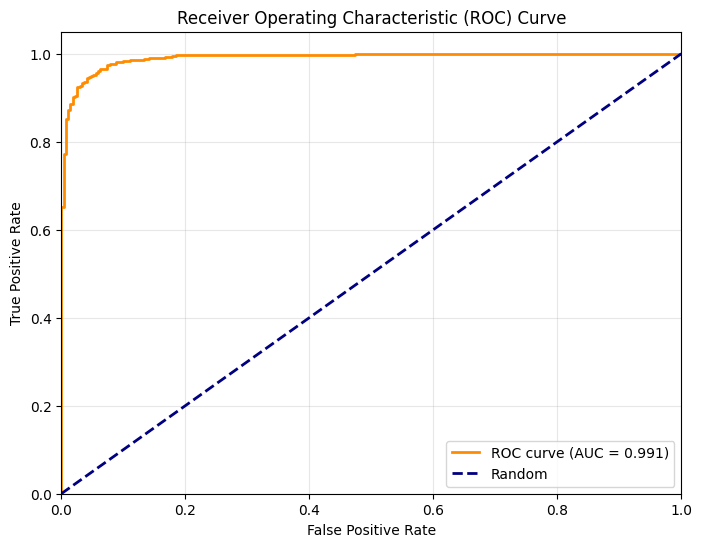

In [69]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(labels_val, predicoes_val)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [71]:
print(f"\n📊 Estatísticas das probabilidades:")
print("NORMAL")
print(f"Min: {predicoes_val[labels_val==0].min():.4f}")
print(f"Max: {predicoes_val[labels_val==0].max():.4f}")
print(f"Média: {predicoes_val[labels_val==0].mean():.4f}")
print(f"\nPNEUMONIA")
print(f"Min: {predicoes_val[labels_val==1].min():.4f}")
print(f"Max: {predicoes_val[labels_val==1].max():.4f}")
print(f"Média: {predicoes_val[labels_val==1].mean():.4f}")


📊 Estatísticas das probabilidades:
NORMAL
Min: 0.0178
Max: 0.9995
Média: 0.5106

PNEUMONIA
Min: 0.4585
Max: 1.0000
Média: 0.9942


###Salvando o modelo

In [72]:
# Carregando o modelo
best_model.save('/content/modelo_pneumonia_final.h5')
print("✅ Salvo: modelo_pneumonia_final.h5")

# Download
files.download('/content/modelo_pneumonia_final.h5')

✅ Salvo: modelo_pneumonia_final.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Aplicação do Grad-Cam

In [73]:
# Geração do Grad-Cam
def gerar_grad_cam(model, img_array, ultima_camada='conv5_block16_concat'):
    grad_model = tf.keras.models.Model(
        inputs  = model.input,
        outputs = [model.get_layer(ultima_camada).output, model.output],
        )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        prob_pneumonia = predictions[:, 0]

    grads = tape.gradient(prob_pneumonia, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

In [74]:
def visualizar_grad_cam(filepath, model, prob_predita):
    img_original = Image.open(filepath).convert('L')
    img_original = ImageOps.pad(img_original, (224, 224), color=0)
    img_rgb = np.array(img_original)

    # Imagem normalizada para o modelo
    img_array = carregar_imagem(filepath)
    img_array = np.expand_dims(img_array, axis=0)

    # Gera heatmap
    heatmap         = gerar_grad_cam(model, img_array)
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_colored = cv2.applyColorMap(
        np.uint8(255 * heatmap_resized),
        cv2.COLORMAP_JET,
        )
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    img_rgb_3ch = np.stack([img_rgb, img_rgb, img_rgb], axis=-1)
    sobreposicao = (heatmap_colored * 0.4 + img_rgb_3ch * 0.6).astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(img_rgb, cmap='bone')
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(heatmap_resized, cmap='jet')
    axes[1].set_title('Mapa de Calor')
    axes[1].axis('off')

    axes[2].imshow(sobreposicao)
    axes[2].set_title(f'Grad-CAM\nProb Pneumonia: {prob_predita:.2%}')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_3']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


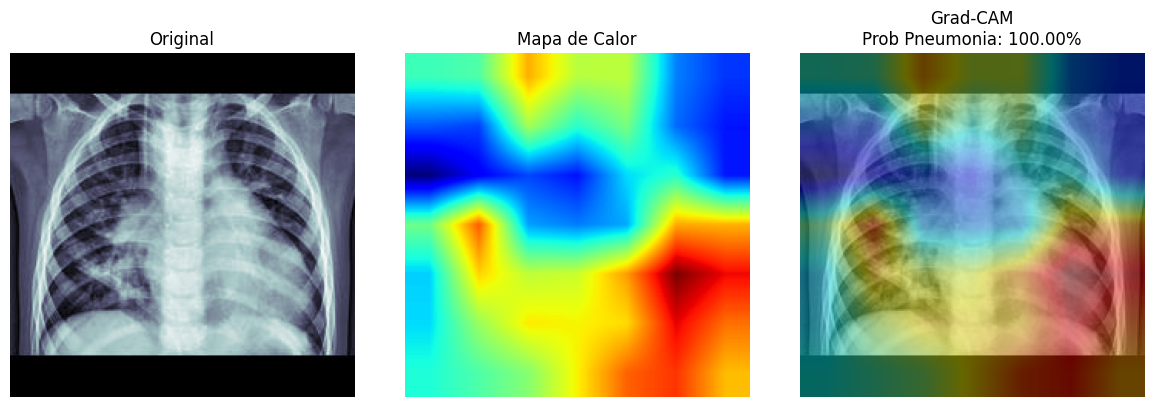

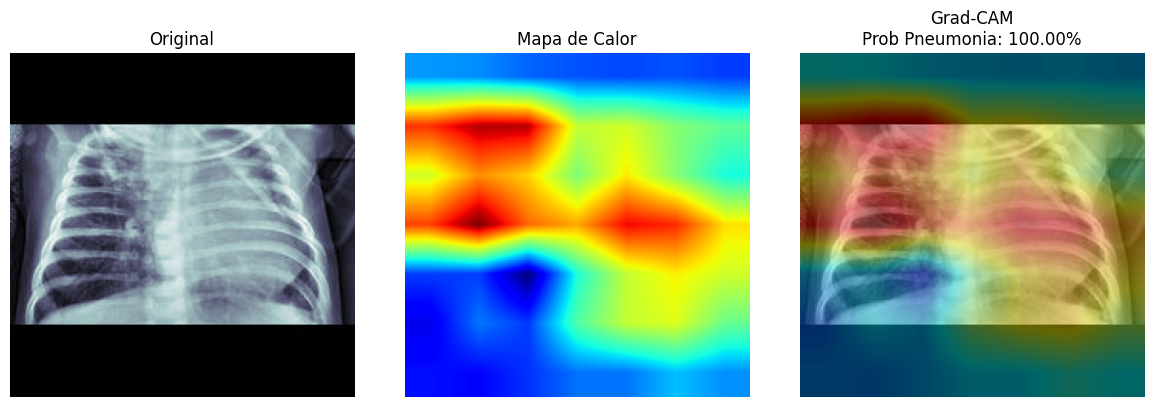

In [75]:
# Visualiza exemplos do Grad-Cam
amostras = df_val.sample(2, random_state=42)

for _, row in amostras.iterrows():
    visualizar_grad_cam(row['filepath'], best_model, row['label_bin'])

###Predição de teste

In [76]:
print("Gerando predições...")

predicoes = []

for idx, row in df_test.iterrows():
    image_id = row['id']
    filepath = os.path.join(test_path, image_id)

    try:
        img = carregar_imagem(filepath)
        img = np.expand_dims(img, axis=0)

        prob = best_model.predict(img, verbose=0)[0][0]
        predicoes.append(float(prob))

        # Progresso
        if (idx + 1) % 50 == 0:
            print(f"   Processadas: {idx + 1}/{len(df_test)}")

    except Exception as e:
        print(f"⚠️ Erro ao processar {image_id}: {e}")
        predicoes.append(0.5)

print(f"\n✅ Predições concluídas: {len(predicoes)} imagens")

Gerando predições...
   Processadas: 50/624
   Processadas: 100/624
   Processadas: 150/624
   Processadas: 200/624
   Processadas: 250/624
   Processadas: 300/624
   Processadas: 350/624
   Processadas: 400/624
   Processadas: 450/624
   Processadas: 500/624
   Processadas: 550/624
   Processadas: 600/624

✅ Predições concluídas: 624 imagens


In [ ]:
# Criação do dataframe
df_submission = pd.DataFrame({
    'id': df_test['id'],
    'target': predicoes
    })

# Verifica o formato
print("Primeiras linhas do CSV de submissão:")
print(df_submission.head(10))

print("Últimas linhas:")
print(df_submission.tail(10))

print(f"📊 Estatísticas das predições:")
print(f"   Mínimo:  {df_submission['target'].min():.4f}")
print(f"   Máximo:  {df_submission['target'].max():.4f}")
print(f"   Média:   {df_submission['target'].mean():.4f}")
print(f"   Mediana: {df_submission['target'].median():.4f}")

Primeiras linhas do CSV de submissão:
              id    target
0  img_0001.jpeg  0.960547
1  img_0002.jpeg  0.991234
2  img_0003.jpeg  0.999952
3  img_0004.jpeg  0.998410
4  img_0005.jpeg  0.996837
5  img_0006.jpeg  0.978379
6  img_0007.jpeg  0.941857
7  img_0008.jpeg  0.999506
8  img_0009.jpeg  0.959505
9  img_0010.jpeg  0.996666
Últimas linhas:
                id    target
614  img_0615.jpeg  0.999999
615  img_0616.jpeg  0.999990
616  img_0617.jpeg  0.999690
617  img_0618.jpeg  0.999864
618  img_0619.jpeg  0.999198
619  img_0620.jpeg  0.999611
620  img_0621.jpeg  0.998647
621  img_0622.jpeg  0.999928
622  img_0623.jpeg  0.999901
623  img_0624.jpeg  0.999996
📊 Estatísticas das predições:
   Mínimo:  0.3898
   Máximo:  1.0000
   Média:   0.9744
   Mediana: 0.9997


In [79]:
# Salvando o csv
submission_filename = '/content/submission.csv'
df_submission.to_csv(submission_filename, index=False)

print(f"✅ CSV de submissão salvo: {submission_filename}")
print(f"   Total de linhas: {len(df_submission)}")

print("\n🔍 Validando formato:")
df_check = pd.read_csv(submission_filename)
print(f"   ✅ Colunas: {list(df_check.columns)}")
print(f"   ✅ Valores entre 0-1: {df_check['target'].between(0, 1).all()}")
print(f"   ✅ Sem valores nulos: {df_check['target'].notna().all()}")
print(f"   ✅ Tamanho: {len(df_check)} linhas")

files.download(submission_filename)

✅ CSV de submissão salvo: /content/submission.csv
   Total de linhas: 624

🔍 Validando formato:
   ✅ Colunas: ['id', 'target']
   ✅ Valores entre 0-1: True
   ✅ Sem valores nulos: True
   ✅ Tamanho: 624 linhas


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>